In [1]:
import anndata
import pixelator
import torch
import scvi
import scipy
# from scvi import autotune

import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

# import ray
# from ray import tune


from pxl_utils import convert_edgelist_to_protein_pair_colocalization, pair2str, apply_func_to_neighbors

import tempfile

from scvi import REGISTRY_KEYS
from scvi.module.base import (
    BaseModuleClass,
    LossOutput,
    PyroBaseModuleClass,
    auto_move_data,
)
from torch.distributions import NegativeBinomial, Normal, Poisson
from torch.distributions import kl_divergence as kl

%load_ext autoreload
%autoreload 2

In [2]:
# ray.init(log_to_driver=False)

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

Seed set to 0


Last run with scvi-tools version: 1.2.2.post1


In [4]:
pg_data = pixelator.read('/home/labs/nyosef/eitangr/pixelgen/PixelGen/datasets/combined_resting_PHA_data_PROCESSED.pxl')
adata = anndata.read_h5ad('/home/labs/nyosef/eitangr/pixelgen/PixelGen/datasets/combined_resting_PHA_data_PROCESSED_WITH_ASYMM_COLOC_NO_OVERLAP.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 3763 × 75
    obs: 'pixels', 'a_pixels', 'b_pixels', 'antibodies', 'molecules', 'reads', 'mean_reads_per_molecule', 'median_reads_per_molecule', 'mean_b_pixels_per_a_pixel', 'median_b_pixels_per_a_pixel', 'mean_a_pixels_per_b_pixel', 'median_a_pixels_per_b_pixel', 'a_pixel_b_pixel_ratio', 'mean_molecules_per_a_pixel', 'median_molecules_per_a_pixel', 'leiden', 'tau_type', 'tau', 'sample', 'n_antibodies_by_counts', 'log1p_n_antibodies_by_counts', 'total_counts', 'log1p_total_counts', 'sample_class', 'cell_type'
    var: 'antibody_count', 'components', 'antibody_pct', 'nuclear', 'control', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors', 'coloc_info', 'counts_per_sample', 'dendrogram_leiden', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sample_class_colors', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'marker_counts_and_pa

In [5]:
from tests import test_convert_edgelist_to_protein_pair_colocalization

test_convert_edgelist_to_protein_pair_colocalization(verbose=False)

[13/01/25 16:43:16]: Starting conversion...


100%|██████████| 1/1 [00:00<00:00, 12.00it/s]

[13/01/25 16:43:17]: Finished conversion!


In [6]:
adata.uns['coloc_info']

{'marker_diff_pair_tuples': array([['ACTB', 'B2M'],
        ['ACTB', 'CD102'],
        ['ACTB', 'CD11a'],
        ...,
        ['mIgG2b', 'TCRVB5'],
        ['mIgG2b', 'mIgG1'],
        ['mIgG2b', 'mIgG2a']], dtype=object),
 'nbhd_radius': 1,
 'pxl_type': 'a'}

In [7]:
coloc_adata = anndata.AnnData(
    X=adata.obsm['marker_counts_and_pair_coloc'], 
    obs=adata.obs, 
    obsm={'counts': adata.layers['counts'], 'counts_clr': adata.layers['clr'], 'marker_pair_coloc': adata.obsm['marker_pair_coloc']},
    uns = {
        'neighbors_counts_clr_both_samples': adata.uns['neighbors'],
        'leiden_counts_clr_both_samples': adata.uns['leiden'],   
    }
)

coloc_adata.obs.rename(columns={'leiden': 'leiden_counts_clr_both_samples'}, inplace=True)

resting_coloc_adata = coloc_adata[coloc_adata.obs[coloc_adata.obs['sample_class'] == 'resting'].index, :].copy()
stim_coloc_adata = coloc_adata[coloc_adata.obs[coloc_adata.obs['sample_class'] == 'stimulated'].index, :].copy()


sc.pp.highly_variable_genes(
    resting_coloc_adata,
    n_top_genes=2000,
    flavor="seurat_v3",
    inplace=True,
    batch_key="sample",
)
# hvg_resting_coloc_adata = resting_coloc_adata[:, resting_coloc_adata.var[resting_coloc_adata.var['highly_variable']].index].copy()
hvg_resting_coloc_adata = resting_coloc_adata.copy()

# hvg_coloc_adata = coloc_adata

# print(coloc_adata.var[coloc_adata.var['highly_variable']])
# hvg_coloc_adata = coloc_adata


In [8]:
marker_pair_str_names = [pair2str(p[0], p[1]) for p in adata.uns['coloc_info']['marker_diff_pair_tuples']]
coloc_adata.var['is_pair'] = coloc_adata.var.index.isin(marker_pair_str_names)
hvg_resting_coloc_adata.var['is_pair'] = hvg_resting_coloc_adata.var.index.isin(marker_pair_str_names)

<Axes: xlabel='means', ylabel='variances_norm'>

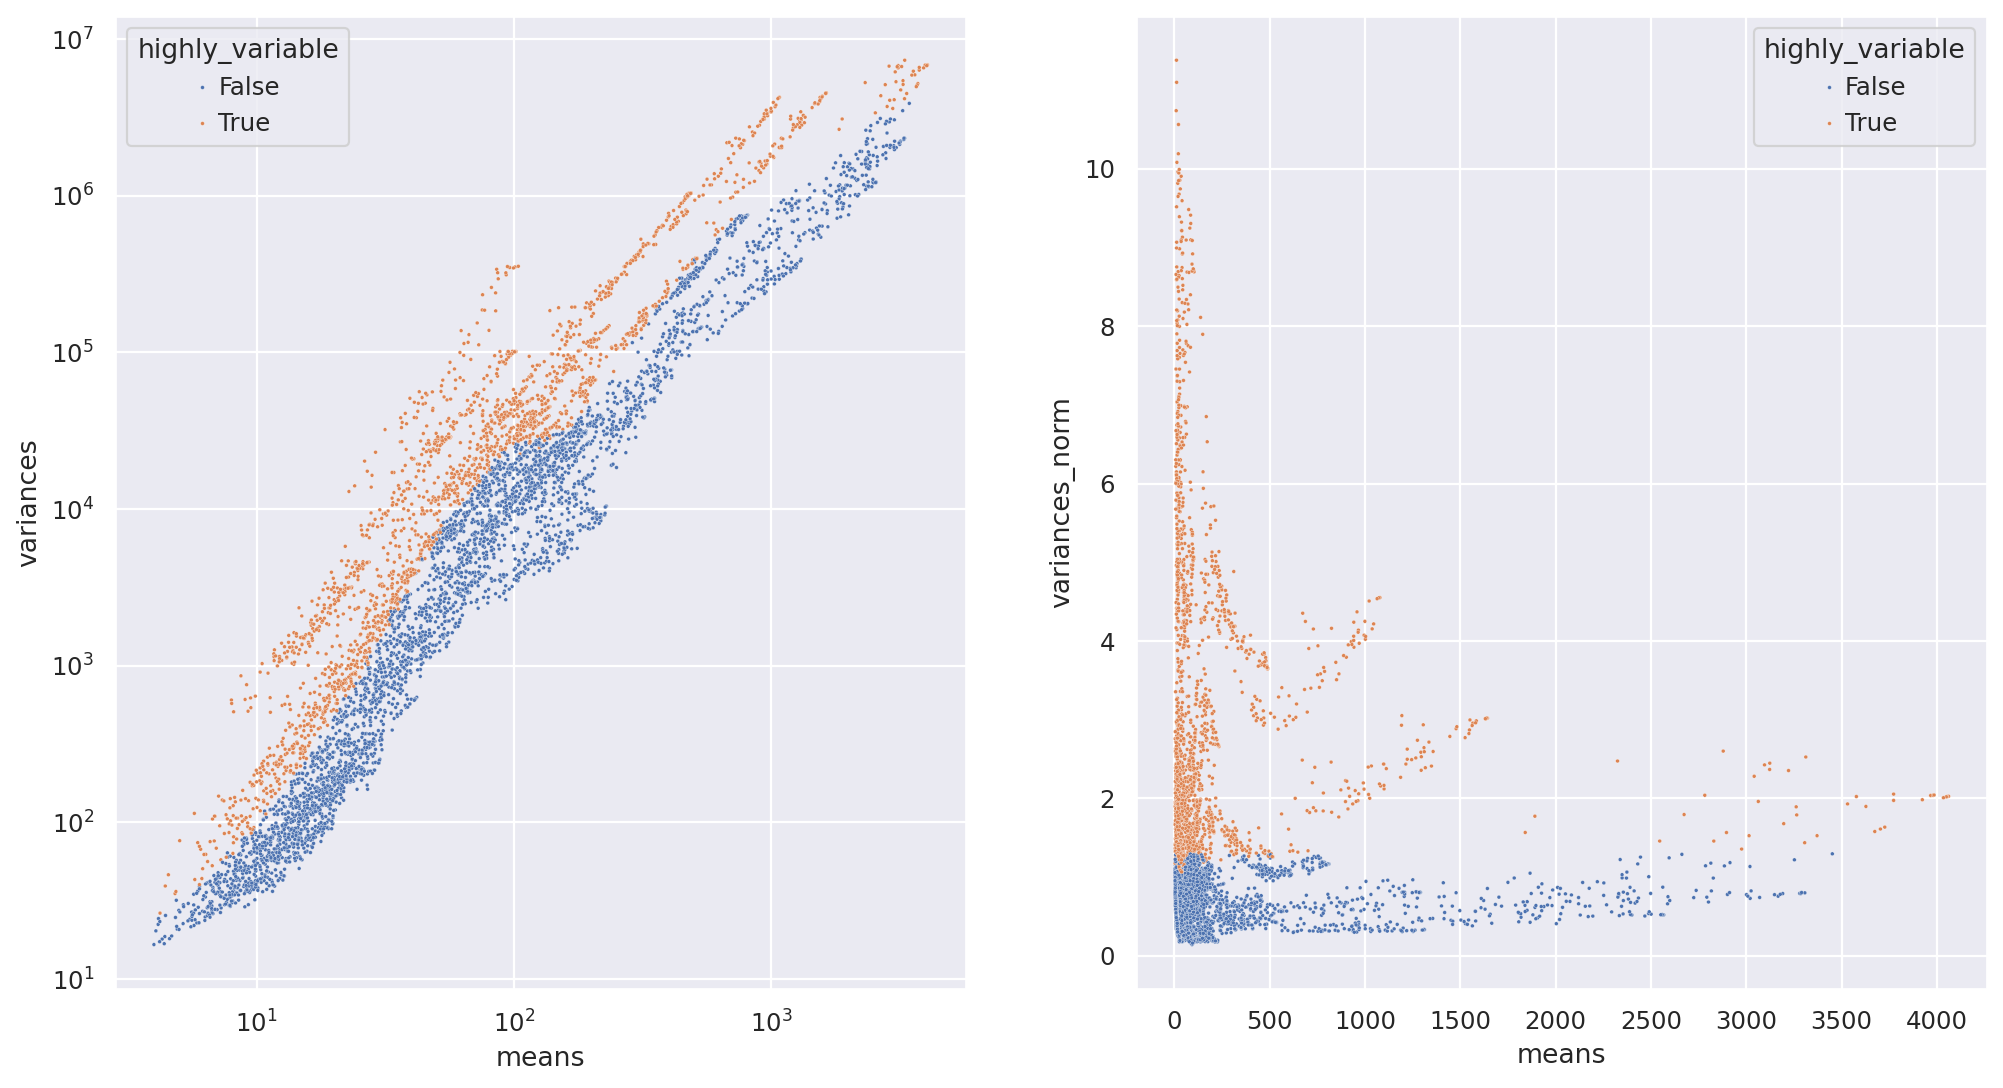

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.scatterplot(x=resting_coloc_adata.var['means'], y=resting_coloc_adata.var['variances'], s=3, ax=ax[0], hue=resting_coloc_adata.var['highly_variable'])
ax[0].loglog()

sns.scatterplot(x=resting_coloc_adata.var['means'], y=resting_coloc_adata.var['variances_norm'], s=3, ax=ax[1], hue=resting_coloc_adata.var['highly_variable'])
# sns.scatterplot(x=resting_coloc_adata.var['means'], y=resting_coloc_adata.var['variances'], s=3, ax=ax[1])

In [10]:
coloc_adata.to_df().head(5)

B2M  CD102  CD11a  CD11b  CD11c  CD14  CD150  \
component                                                                 
RCVCMP0000000_resting_r1  4690    349    509     81    679    50     23   
RCVCMP0000001_resting_r1  3379     94    262    156     50    78    105   
RCVCMP0000002_resting_r1  3070     39    202     58     35    42     30   
RCVCMP0000004_resting_r1  2014     26     63     92     18    19     27   
RCVCMP0000005_resting_r1  6731    227    240    185    112    79    134   

                          CD152  CD154  CD158  ...  (mIgG2b,CD8)  \
component                                      ...                 
RCVCMP0000000_resting_r1     13     31     33  ...             7   
RCVCMP0000001_resting_r1     21     34     78  ...            12   
RCVCMP0000002_resting_r1     17     36     29  ...            12   
RCVCMP0000004_resting_r1     14     16     25  ...             5   
RCVCMP0000005_resting_r1     66     60    101  ...            22   

                          (mIgG2b,CD82)  (mIgG2b,CD84)  (mIgG2b,CD86)  \
component                                                               
RCVCMP0000000_resting_r1             10             11             13   
RCVCMP0000001_resting_r1             11              8              8   
RCVCMP0000002_resting_r1             17             14              8   
RCVCMP0000004_resting_r1              7              4              3   
RCVCMP0000005_resting_r1             31             15             11   

                          (mIgG2b,CD9)  (mIgG2b,HLA-ABC)  (mIgG2b,HLA-DR)  \
component                                                                   
RCVCMP0000000_resting_r1             7                15               15   
RCVCMP0000001_resting_r1             9                11               10   
RCVCMP0000002_resting_r1            14                17               17   
RCVCMP0000004_resting_r1             6                 8                3   
RCVCMP0000005_resting_r1            23                32               22   

                          (mIgG2b,TCRVB5)  (mIgG2b,mIgG1)  (mIgG2b,mIgG2a)  
component                                                                   
RCVCMP0000000_resting_r1                5               5                3  
RCVCMP0000001_resting_r1                5               9                3  
RCVCMP0000002_resting_r1               12              13               14  
RCVCMP0000004_resting_r1                5               1                2  
RCVCMP0000005_resting_r1               12               8               16  

[5 rows x 5625 columns]

In [11]:
counts_adata = pg_data.adata
counts_adata.X = counts_adata.layers['counts']
resting_counts_adata = counts_adata[counts_adata.obs[counts_adata.obs['sample_class'] == 'resting'].index, :].copy()
stim_counts_adata = counts_adata[counts_adata.obs[counts_adata.obs['sample_class'] == 'stimulated'].index, :].copy()

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_elem from `anndata.experimental` is deprecated. Import anndata.io.read_elem instead.
  warnings.warn(msg, FutureWarning)


In [12]:
counts_adata.to_df().head(5)

marker                     B2M  CD102  CD11a  CD11b  CD11c  CD14  CD150  \
component                                                                 
RCVCMP0000000_resting_r1  4690    349    509     81    679    50     23   
RCVCMP0000001_resting_r1  3379     94    262    156     50    78    105   
RCVCMP0000002_resting_r1  3070     39    202     58     35    42     30   
RCVCMP0000004_resting_r1  2014     26     63     92     18    19     27   
RCVCMP0000005_resting_r1  6731    227    240    185    112    79    134   

marker                    CD152  CD154  CD158  ...  CD84  CD86  CD9  HLA-ABC  \
component                                      ...                             
RCVCMP0000000_resting_r1     13     31     33  ...    30   262   68     1961   
RCVCMP0000001_resting_r1     21     34     78  ...    39    16   38     1215   
RCVCMP0000002_resting_r1     17     36     29  ...    35    18   40     1395   
RCVCMP0000004_resting_r1     14     16     25  ...    53    15   69      758   
RCVCMP0000005_resting_r1     66     60    101  ...    89    72  172     2066   

marker                    HLA-DR  TCRVB5  ACTB  mIgG1  mIgG2a  mIgG2b  
component                                                              
RCVCMP0000000_resting_r1     763      19    67     14      22      15  
RCVCMP0000001_resting_r1      61      15    71     24      22      12  
RCVCMP0000002_resting_r1    2871      26    48     17      31      17  
RCVCMP0000004_resting_r1      35      18    31     13      15       8  
RCVCMP0000005_resting_r1     267      65   179     46      82      44  

[5 rows x 75 columns]

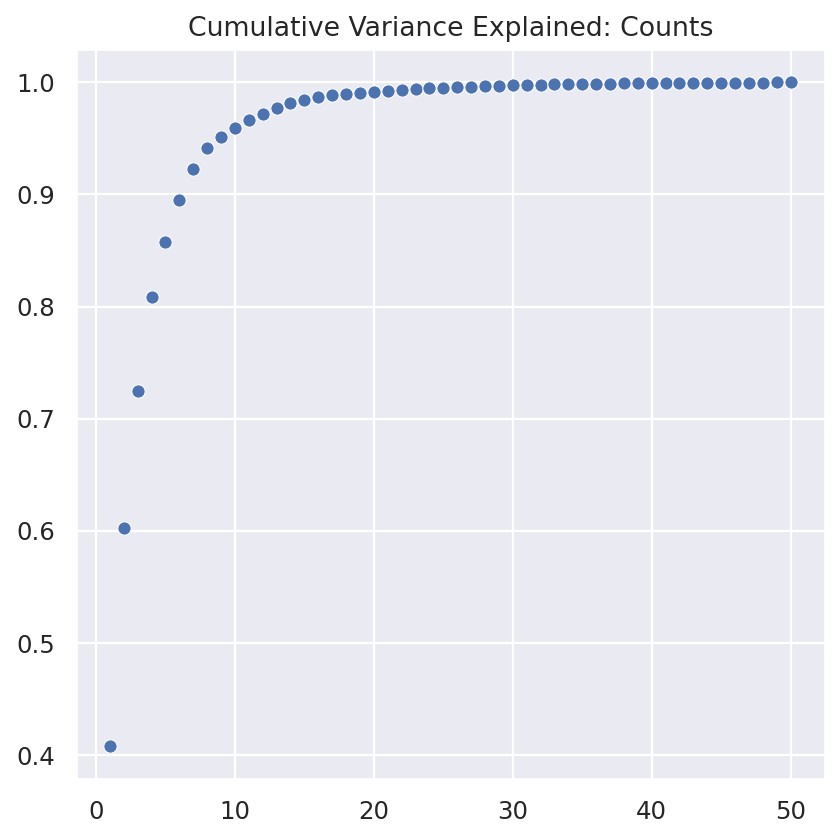

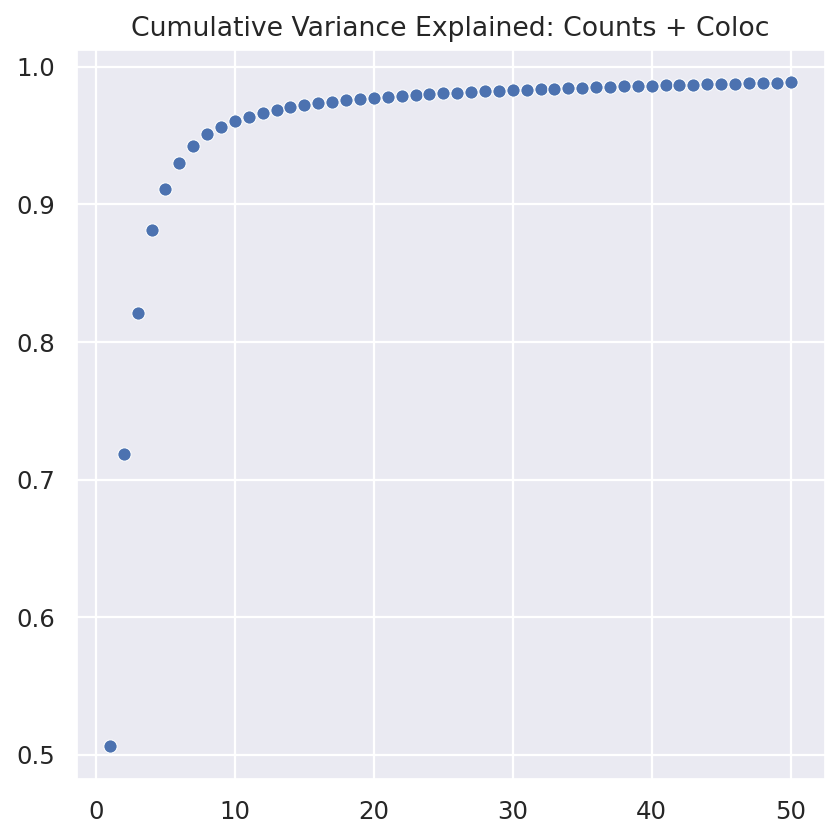

In [13]:
for current_adata in (resting_counts_adata, hvg_resting_coloc_adata):
    n_pcs = 50
    sc.tl.pca(current_adata)
    # sc.pl.pca_variance_ratio(current_adata, n_pcs=n_pcs, log=True)

    fig_intersection, ax = plt.subplots(1)
    var_ratio_accum = np.cumsum(current_adata.uns['pca']['variance_ratio'])
    sns.scatterplot(x=list(range(1, n_pcs + 1)), y=var_ratio_accum, markers=[f'$PC{i}$' for i in range(1, n_pcs + 1)])
    ax.set_title(f'Cumulative Variance Explained: {"Counts" if current_adata is resting_counts_adata else "Counts + Coloc"}')

/tmp/ipykernel_1190334/589560470.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(current_adata, resolution=1, random_state=0, key_added=leiden_key, flavor='leidenalg', neighbors_key=neighbors_key)


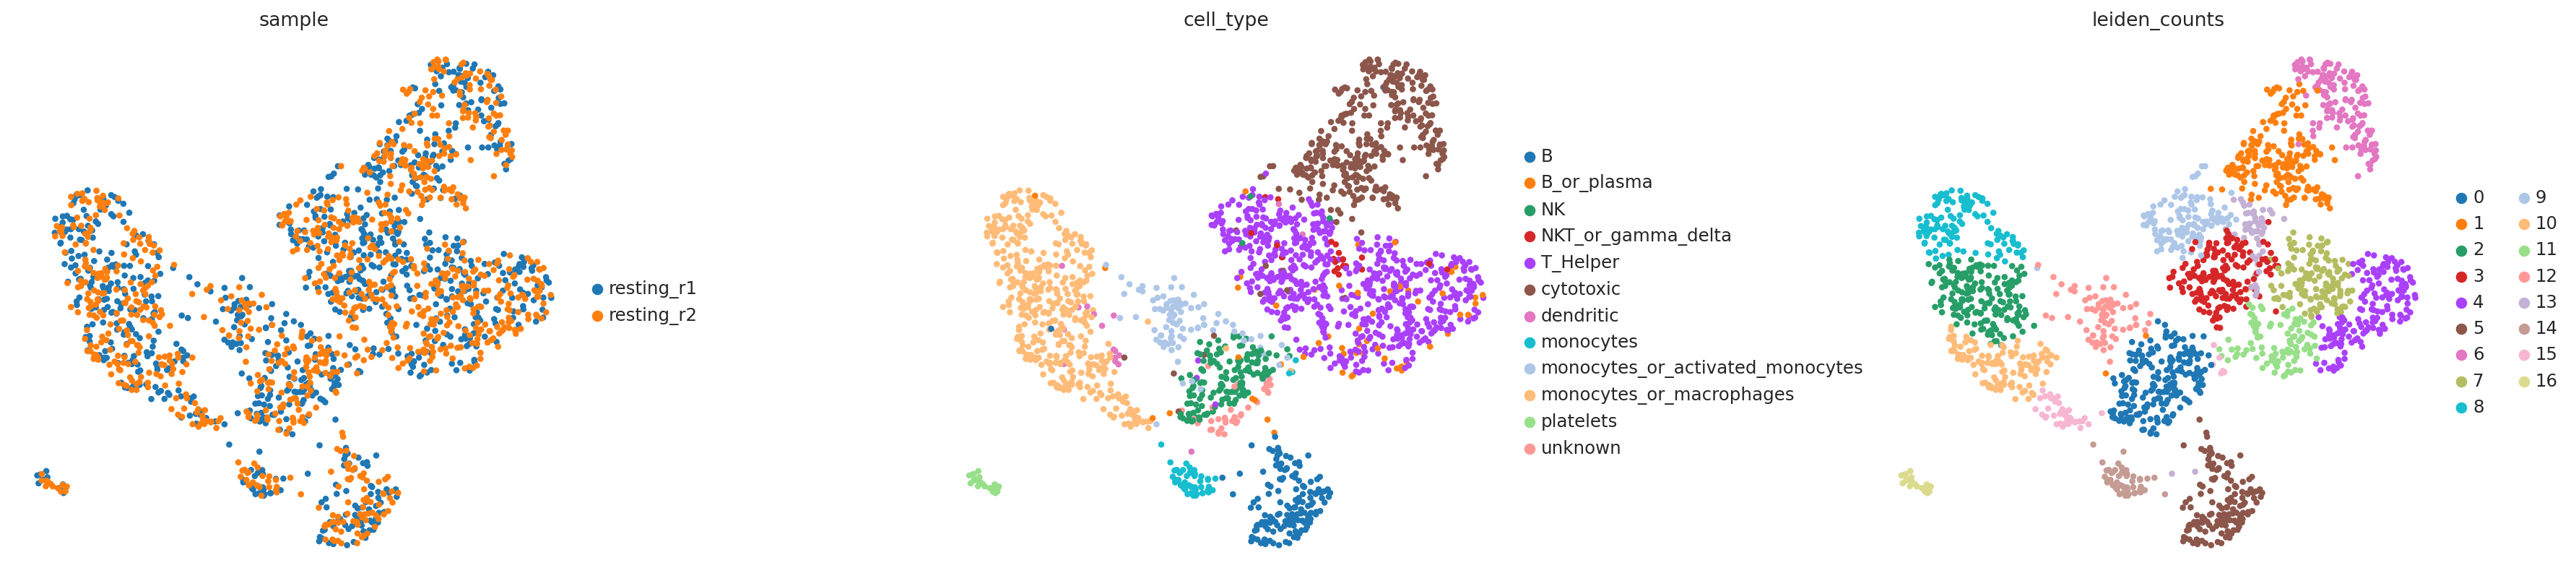

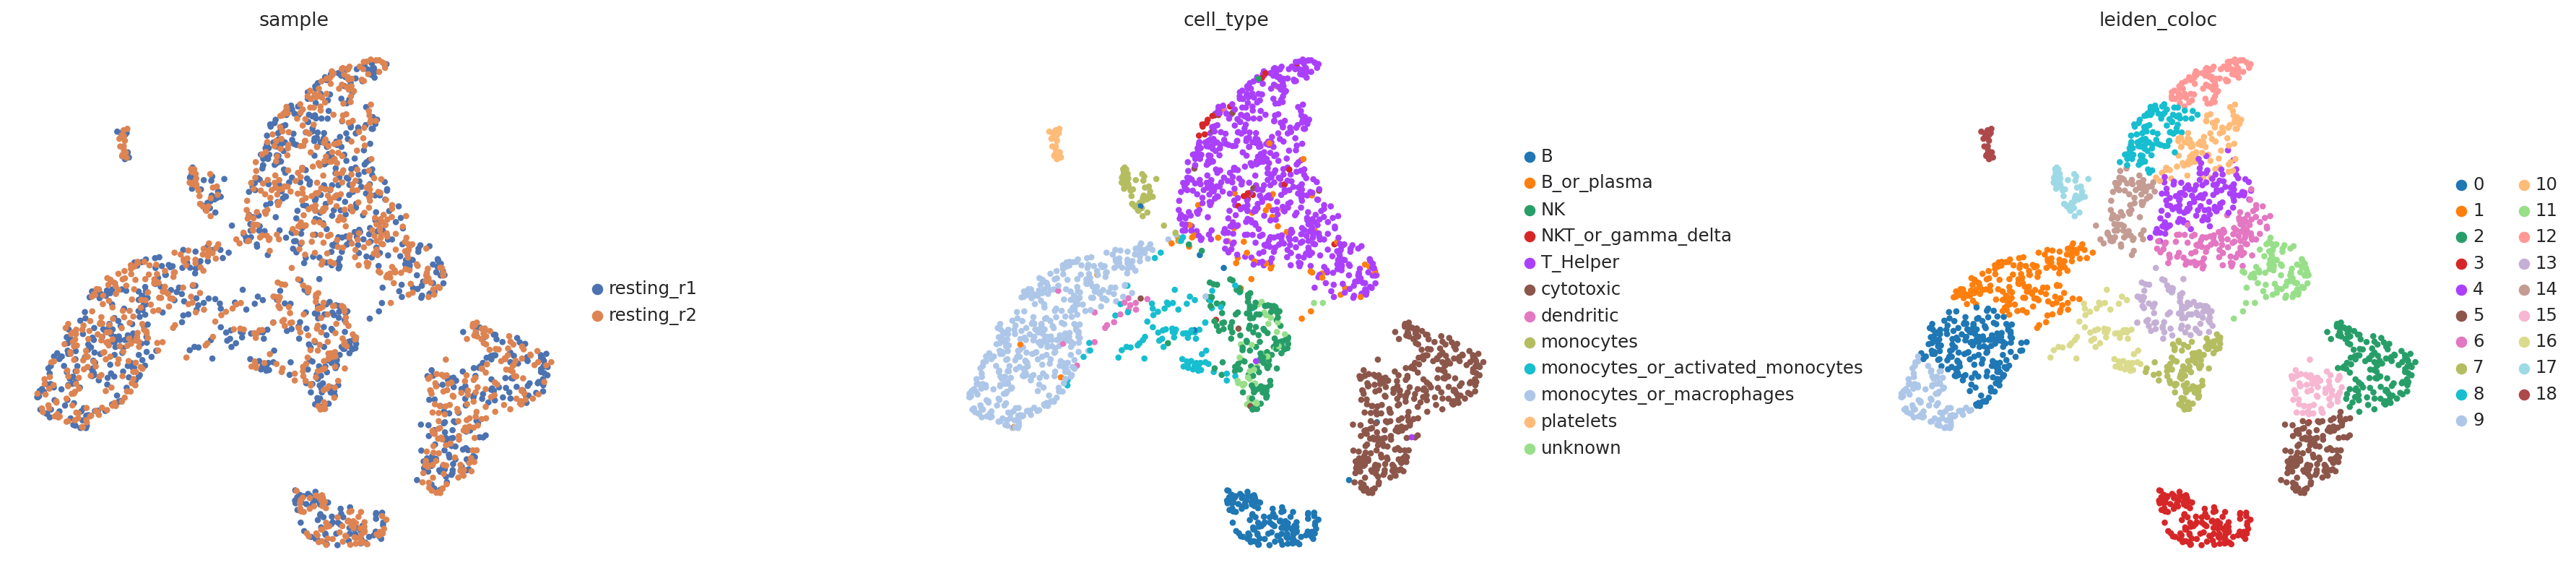

In [14]:
for current_adata in (resting_counts_adata, hvg_resting_coloc_adata):
    neighbors_key = 'neighbors_counts' if current_adata is resting_counts_adata else 'neighbors_coloc'
    leiden_key = 'leiden_counts' if current_adata is resting_counts_adata else 'leiden_coloc'
    sc.pp.neighbors(current_adata, n_neighbors=15, random_state=0, key_added=neighbors_key)
    sc.tl.leiden(current_adata, resolution=1, random_state=0, key_added=leiden_key, flavor='leidenalg', neighbors_key=neighbors_key)
    sc.tl.umap(current_adata, neighbors_key=neighbors_key)
    sc.pl.umap(current_adata, color=['sample', 'cell_type', leiden_key,], wspace=0.5)

In [15]:
scvi.model.SCVI.setup_anndata(resting_counts_adata, batch_key='sample',)

resting_counts_model = scvi.model.SCVI(resting_counts_adata, n_hidden=128, n_layers=2, dispersion='gene-cell', gene_likelihood='zinb', latent_distribution='normal')
resting_counts_model.train(train_size=0.8, check_val_every_n_epoch=1, early_stopping=50, max_epochs=400, plan_kwargs=dict(lr=3e-4, optimizer='Adam', n_epochs_kl_warmup=200))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 349.837. Signaling Trainer to stop.


[]

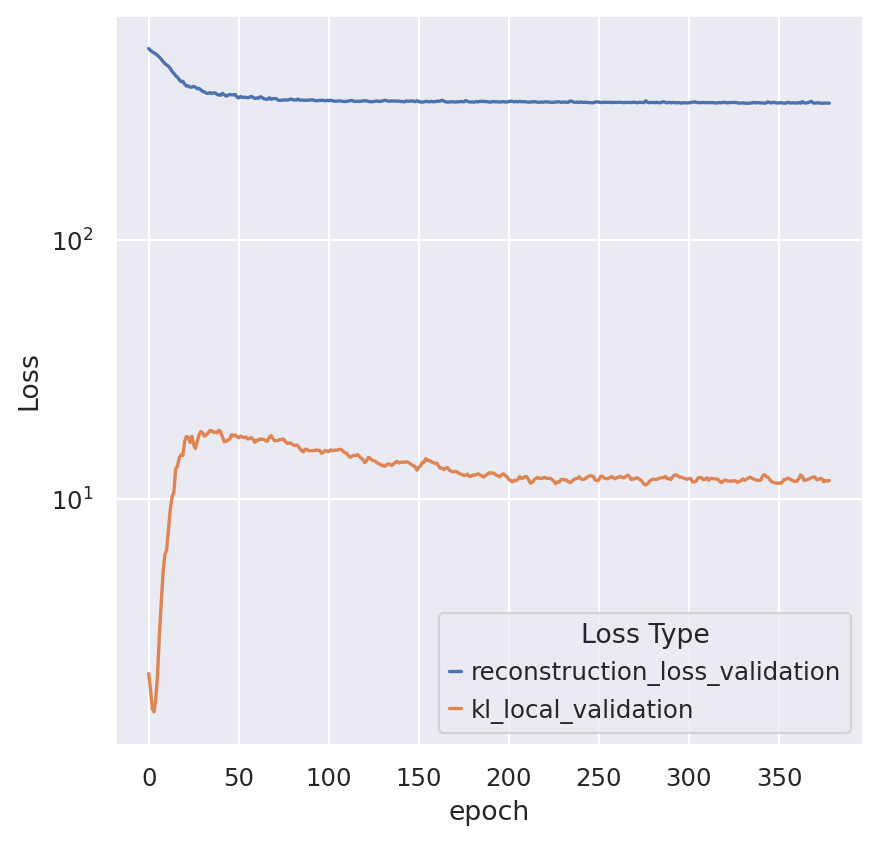

In [16]:
n_epochs = len(resting_counts_model.history['validation_loss'])
validation_losses = ['reconstruction_loss_validation', 'kl_local_validation']
validation_df = pd.melt(pd.DataFrame({l: resting_counts_model.history[l][l] for l in validation_losses}).reset_index(), id_vars=['epoch'], value_name='Loss', var_name='Loss Type')
sns.lineplot(validation_df, x='epoch', y='Loss', hue='Loss Type')
plt.semilogy()

In [17]:
scvi.model.SCVI.setup_anndata(hvg_resting_coloc_adata, batch_key='sample',)

resting_coloc_model = scvi.model.SCVI(hvg_resting_coloc_adata, n_hidden=128, n_layers=2, dispersion='gene-cell', gene_likelihood='zinb', latent_distribution='normal')
resting_coloc_model.train(train_size=0.8, check_val_every_n_epoch=1, early_stopping=50, max_epochs=400, plan_kwargs=dict(lr=3e-4, optimizer='Adam', n_epochs_kl_warmup=200))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 23698.078. Signaling Trainer to stop.


[]

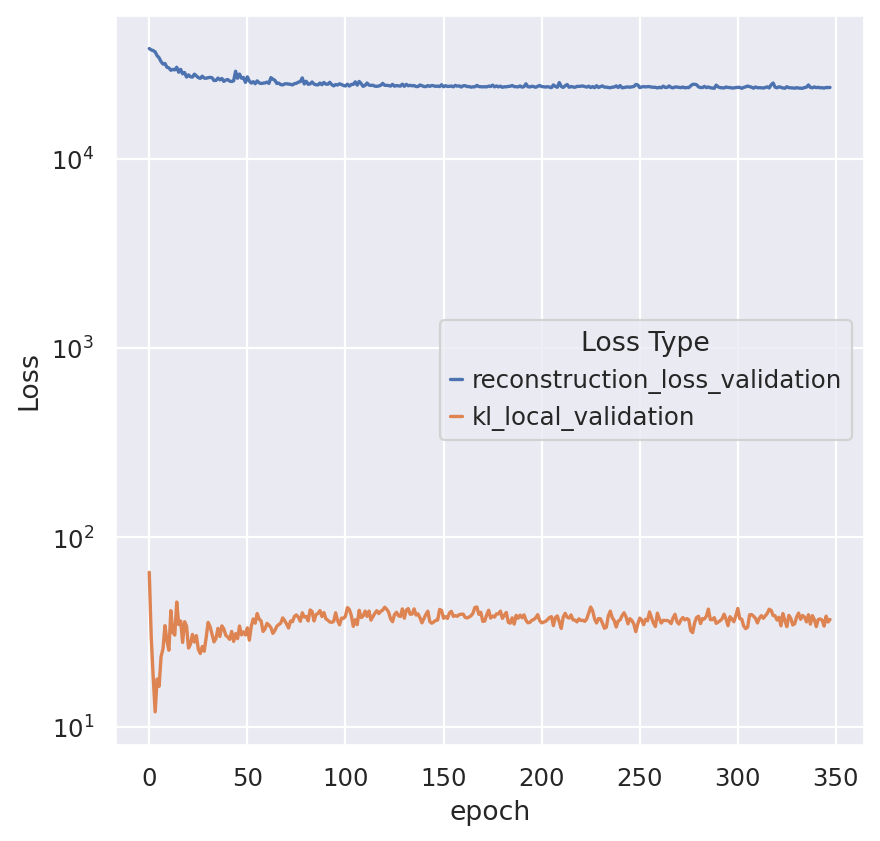

In [18]:
n_epochs = len(resting_coloc_model.history['validation_loss'])
validation_losses = ['reconstruction_loss_validation', 'kl_local_validation']
validation_df = pd.melt(pd.DataFrame({l: resting_coloc_model.history[l][l] for l in validation_losses}).reset_index(), id_vars=['epoch'], value_name='Loss', var_name='Loss Type')
sns.lineplot(validation_df, x='epoch', y='Loss', hue='Loss Type')
plt.semilogy()

### Compute neighbors in new latent space
And measure euclidean distance in the coloc distribution space between neighbors in the latent space

In [19]:
def coloc_distribution_distance(obs1_index, obs2_index, pairs_only_coloc_adata):
    i1, i2 = obs1_index, obs2_index
    return np.linalg.norm(pairs_only_coloc_adata.X[i1] - pairs_only_coloc_adata.X[i2])

In [20]:
pairs_only_coloc_adata = hvg_resting_coloc_adata[:, hvg_resting_coloc_adata.var['is_pair'].index]
pairs_only_coloc_adata.layers['log1p'] = np.log1p(pairs_only_coloc_adata.X)

/tmp/ipykernel_1190334/2206037226.py:2: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  pairs_only_coloc_adata.layers['log1p'] = np.log1p(pairs_only_coloc_adata.X)


In [21]:
correlations = []

for model_type in ('Counts', 'Counts+Coloc'):
    current_adata  = resting_counts_adata if model_type == 'Counts' else hvg_resting_coloc_adata
    model = resting_counts_model if model_type == 'Counts' else resting_coloc_model
    for n_neighbors in tqdm(range(5, 21)):
        neighbors_key = f'neighbors_counts_scvi_{n_neighbors}' if model_type == 'Counts' else f'neighbors_coloc_scvi_{n_neighbors}'
        current_adata.obsm['scvi_latent'] = model.get_latent_representation()
        sc.pp.neighbors(current_adata, n_neighbors=n_neighbors, random_state=0, use_rep='scvi_latent', key_added=neighbors_key)

        neighbors_row, neighbors_col = current_adata.obsp[f'{neighbors_key}_distances'].nonzero()
        obs1 = pairs_only_coloc_adata.X[neighbors_row, :]
        obs2 = pairs_only_coloc_adata.X[neighbors_col, :]

        coloc_distance_data = np.linalg.norm(obs1 - obs2, axis=1)
        n_obs = len(current_adata.obs.index)
        current_adata.obsp[f'{neighbors_key}_distance_in_coloc_space'] = scipy.sparse.csr_matrix((coloc_distance_data, (neighbors_row, neighbors_col)), shape=(n_obs, n_obs))
    
        latent_distance_data = current_adata.obsp[f'{neighbors_key}_distances'].data

        correlations.append(
            {
                'Model': model_type,
                'n_neighbors': n_neighbors,
                'Correlation': scipy.stats.pearsonr(coloc_distance_data, latent_distance_data)[0]
             }
        )

correlations = pd.DataFrame(correlations)

# sc.tl.leiden(current_adata, resolution=1, random_state=0, key_added=leiden_key, flavor='leidenalg', neighbors_key=neighbors_key)
# sc.tl.umap(current_adata, neighbors_key=neighbors_key)

100%|██████████| 16/16 [00:13<00:00,  1.15it/s]


### Global Correlation between distance between neighboring points in latent space, and distance between same points in raw co-localization features

This is a sort of sanity check, as the counts + coloc model was trained to reconstruct the coloc data, so the latent space should reflect that.

Text(0.5, 0, 'Neighbors per Point')

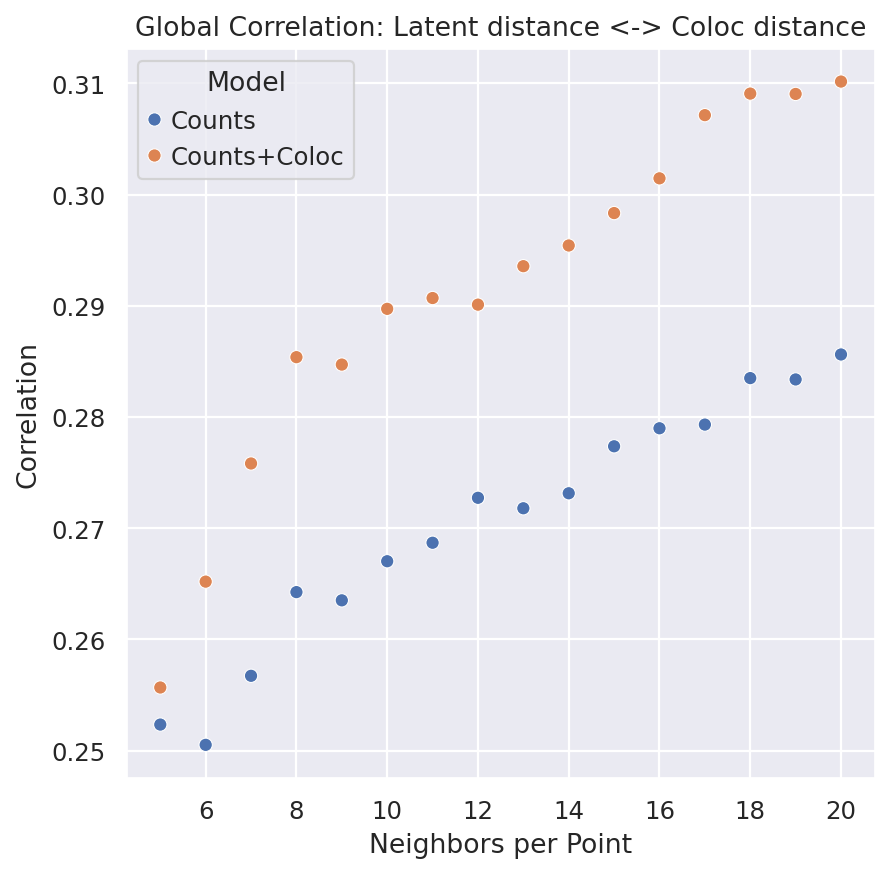

In [26]:
ax = sns.scatterplot(correlations, x='n_neighbors', y='Correlation', hue='Model')
ax.set_title('Global Correlation: Latent distance <-> Coloc distance')
ax.set_xlabel('Neighbors per Point')

### Compute Differential Expression of Marker Pairs Between Clusters of Different Resolution

In [23]:
current_adata.uns[leiden_key]

{'params': {'resolution': 1, 'random_state': 0, 'n_iterations': -1}}

In [24]:
# Use n_neighbors=15 as a default for computing clusters

de = []

for model_type in ('Counts', 'Counts+Coloc'):
    current_adata = resting_counts_adata if model_type == 'Counts' else hvg_resting_coloc_adata
    neighbors_key = 'neighbors_counts_scvi_15' if model_type == 'Counts' else 'neighbors_coloc_scvi_15'
    resolution_range = np.arange(0.2, 2, 0.1)
    for r in tqdm(resolution_range):
        leiden_key = f'leiden_counts_scvi_{r:.1f}'if model_type == 'Counts' else f'leiden_coloc_scvi_{r:.1f}'
        de_key = f'de_counts_{r:.1f}' if model_type == 'Counts' else f'de_coloc_{r:.1f}'
        sc.tl.leiden(current_adata, resolution=r, random_state=0, n_iterations=-1, key_added=leiden_key, flavor='leidenalg', neighbors_key=neighbors_key, copy=False)

        # Drop if already exists (when rerunning)
        pairs_only_coloc_adata.obs.drop(columns=[leiden_key,], inplace=True, errors='ignore')

        pairs_only_coloc_adata.obs = pairs_only_coloc_adata.obs.join(current_adata.obs[leiden_key])
        pairs_only_coloc_adata.uns[leiden_key] = current_adata.uns[leiden_key]
        pairs_only_coloc_adata.uns[leiden_key]['n_clusters'] = n_clusters = current_adata.obs[leiden_key].nunique()
        sc.tl.rank_genes_groups(pairs_only_coloc_adata, layer='log1p', groupby=leiden_key, method='wilcoxon', key_added=de_key)
        significant_hits_df = sc.get.rank_genes_groups_df(pairs_only_coloc_adata, group=None, key=de_key, pval_cutoff=0.05)
        de.append(
            {
                'Model': model_type,
                'n_clusters': n_clusters,
                'resolution': r,
                'n_significant_hits' : len(significant_hits_df)
            }
        )

de_df = pd.DataFrame(de)

 72%|███████▏  | 13/18 [00:24<00:10,  2.04s/it]/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/labs/nyosef/

Text(0.5, 1.0, 'Significant Hits in DE of Coloc vs n_clusters')

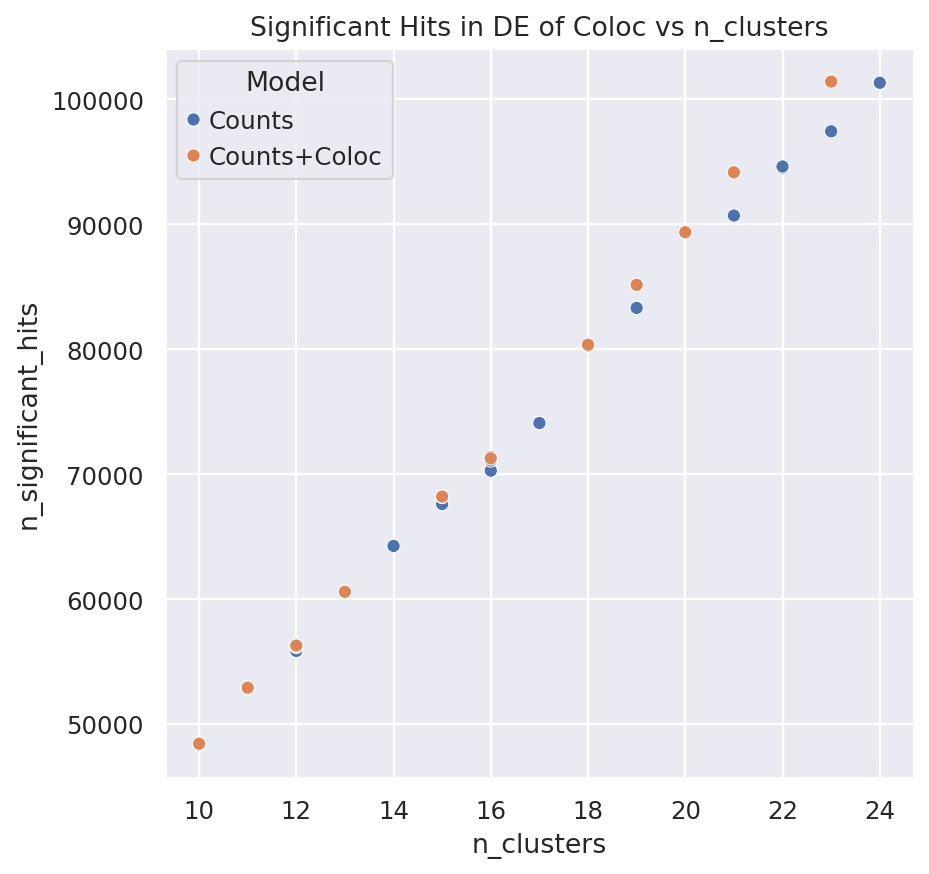

In [25]:
ax = sns.scatterplot(de_df, x='n_clusters', y='n_significant_hits', hue='Model')
ax.set_title('Significant Hits in DE of Coloc vs n_clusters')

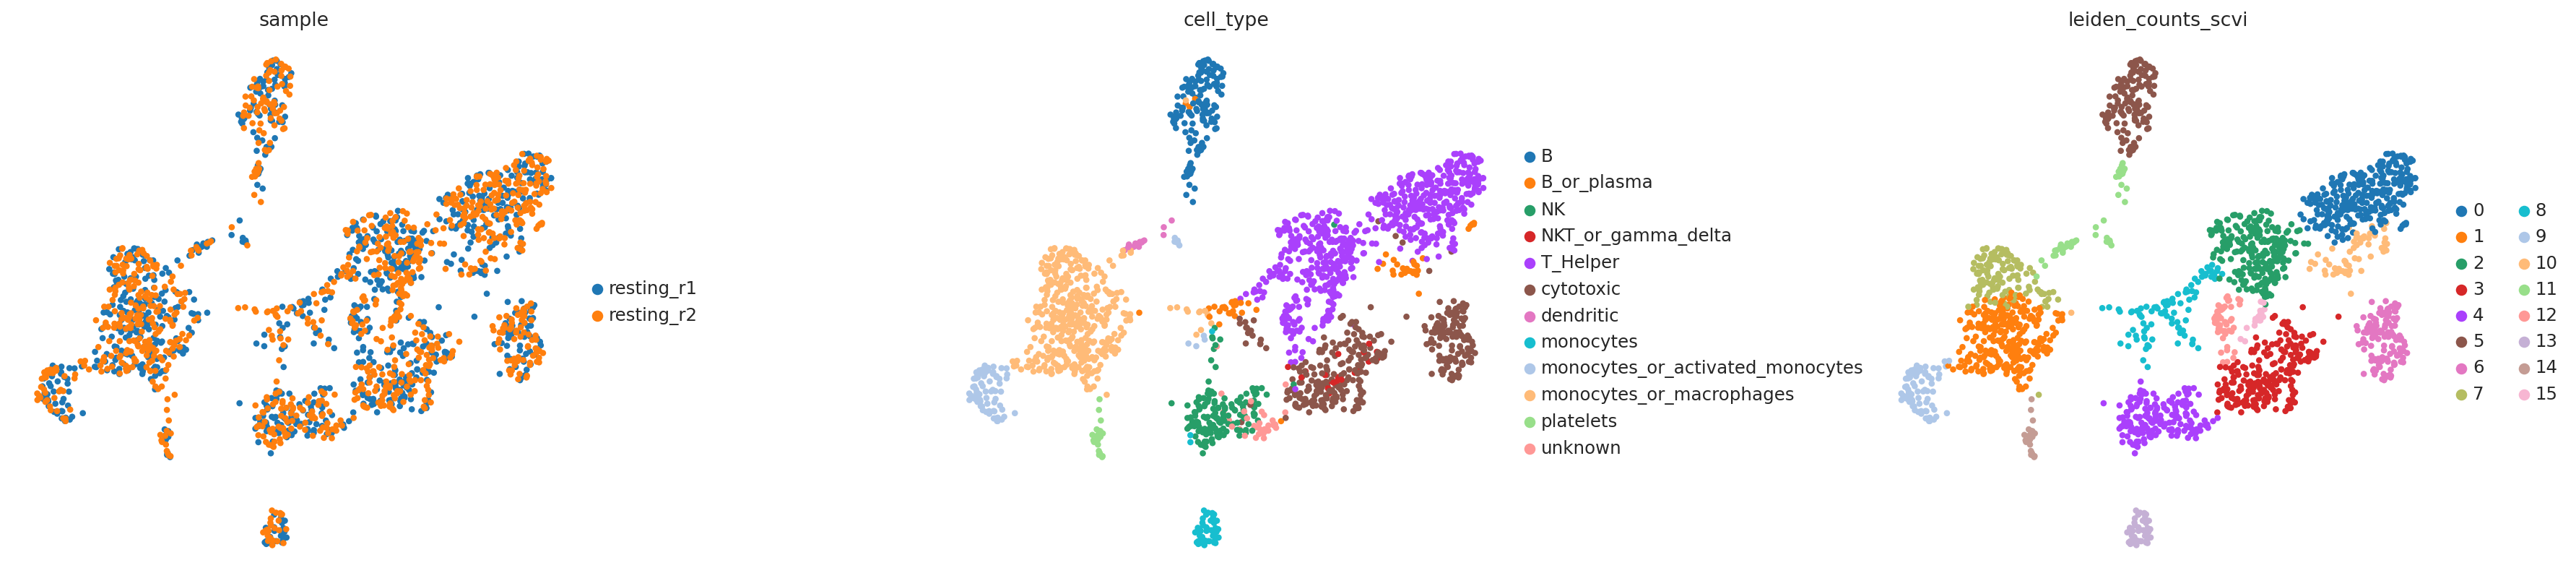

In [ ]:
# resting_counts_adata.obsm['scvi_latent'] = resting_counts_model.get_latent_representation()
# sc.pp.neighbors(resting_counts_adata, n_neighbors=15, random_state=0, use_rep='scvi_latent', key_added='neighbors_counts_scvi')
# sc.tl.leiden(resting_counts_adata, resolution=1, random_state=0, key_added='leiden_counts_scvi', flavor='leidenalg', neighbors_key='neighbors_counts_scvi')
# sc.tl.umap(resting_counts_adata, neighbors_key='neighbors_counts_scvi')
# sc.pl.umap(resting_counts_adata, color=['sample', 'cell_type', 'leiden_counts_scvi',], wspace=0.5)

In [ ]:
# scvi.model.SCVI.setup_anndata(resting_coloc_adata, batch_key='sample',)

# resting_coloc_model = scvi.model.SCVI(resting_coloc_adata, n_hidden=128, n_layers=2, dispersion='gene-cell', gene_likelihood='zinb', latent_distribution='normal')
# resting_coloc_model.train(train_size=0.8, check_val_every_n_epoch=1, early_stopping=50, plan_kwargs=dict(lr=3e-4, optimizer='Adam'))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

<Axes: xlabel='epoch', ylabel='Loss'>

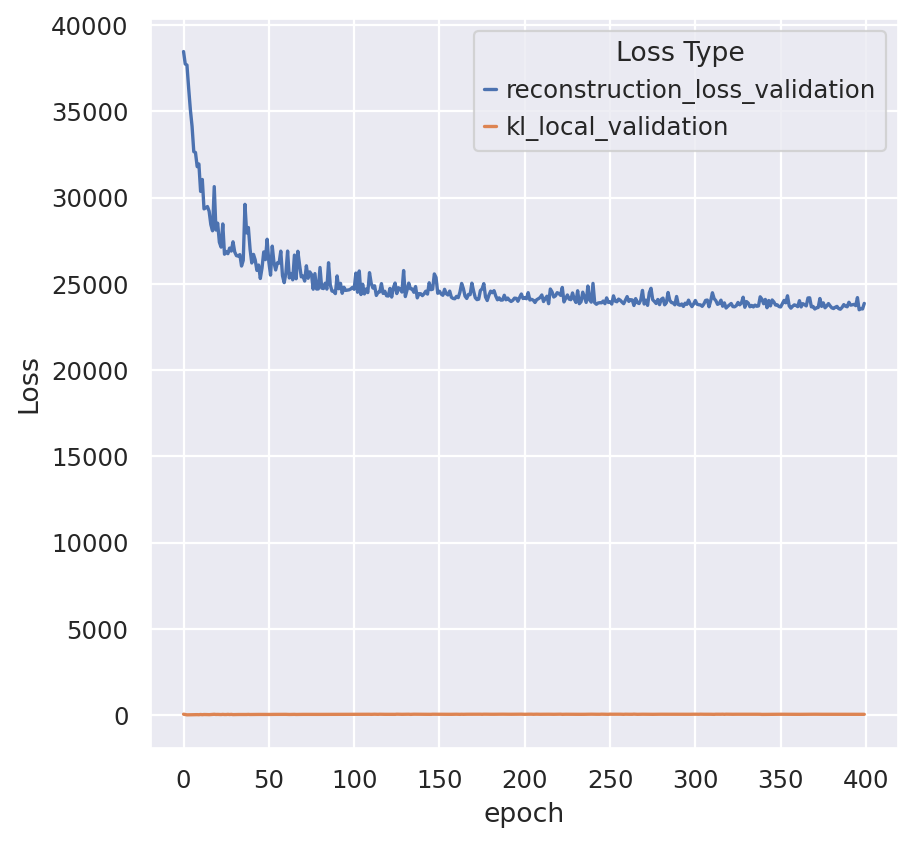

In [ ]:
# n_epochs = len(resting_coloc_model.history['validation_loss'])
# validation_losses = ['reconstruction_loss_validation', 'kl_local_validation']
# validation_df = pd.melt(pd.DataFrame({l: resting_coloc_model.history[l][l] for l in validation_losses}).reset_index(), id_vars=['epoch'], value_name='Loss', var_name='Loss Type')
# sns.lineplot(validation_df, x='epoch', y='Loss', hue='Loss Type')

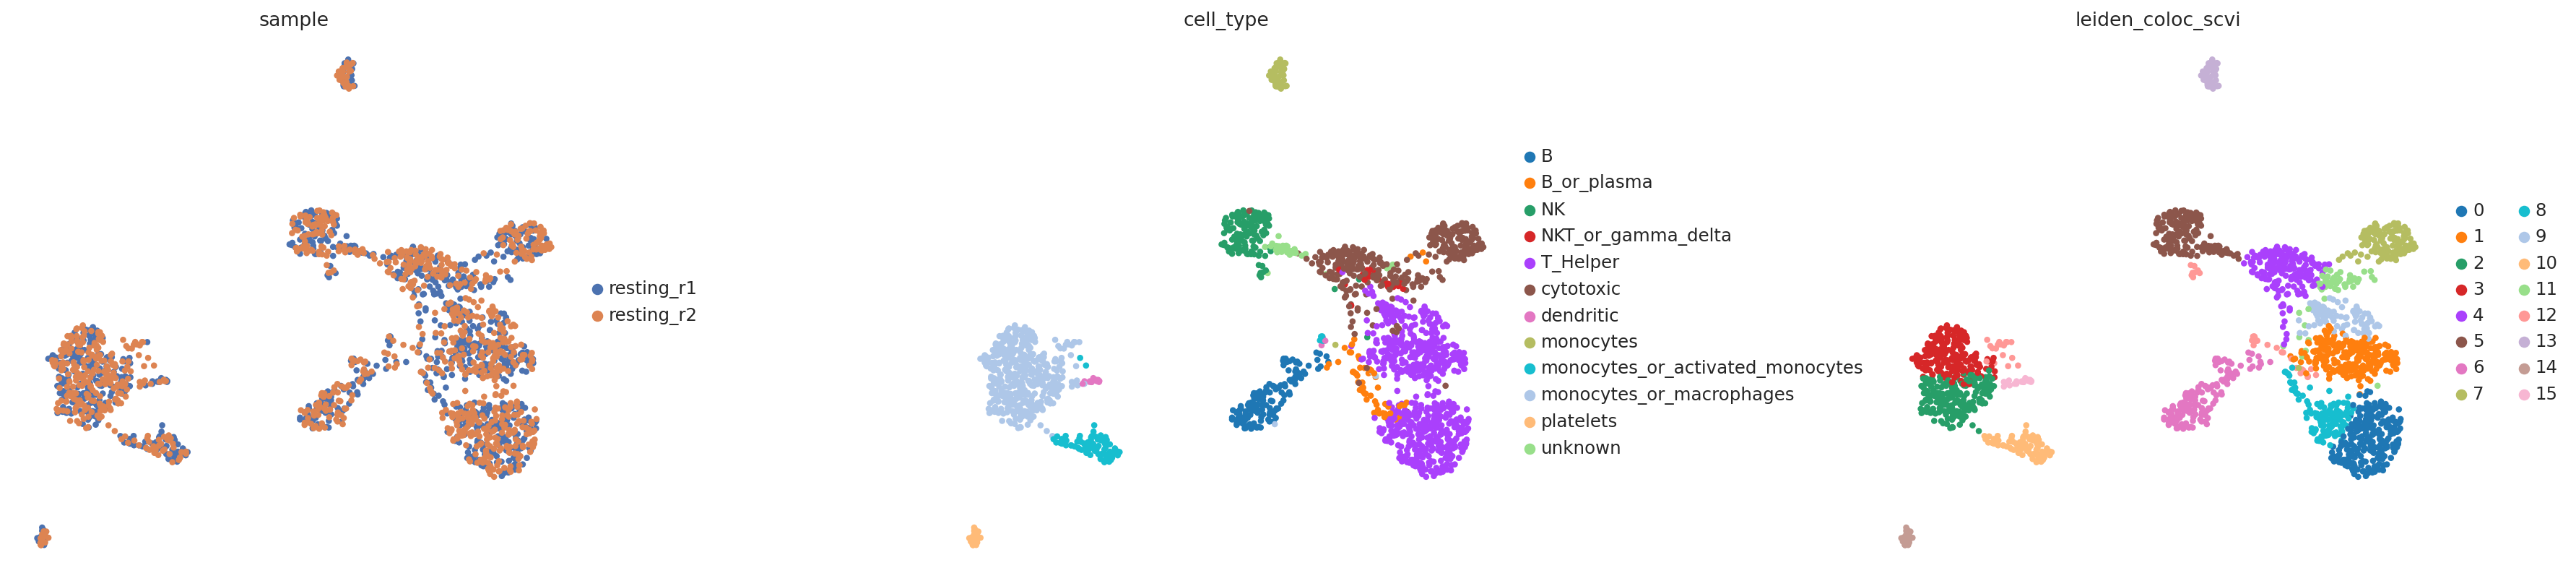

In [ ]:
# resting_coloc_adata.obsm['scvi_latent'] = resting_coloc_model.get_latent_representation()
# sc.pp.neighbors(resting_coloc_adata, n_neighbors=15, random_state=0, use_rep='scvi_latent', key_added='neighbors_coloc_scvi')
# sc.tl.leiden(resting_coloc_adata, resolution=1, random_state=0, key_added='leiden_coloc_scvi', flavor='leidenalg', neighbors_key='neighbors_coloc_scvi')
# sc.tl.umap(resting_coloc_adata, neighbors_key='neighbors_coloc_scvi')
# sc.pl.umap(resting_coloc_adata, color=['sample', 'cell_type', 'leiden_coloc_scvi',], wspace=0.5)

### Finished here

In [ ]:
# Compute leiden for resting sample only, based on the counts clr data

resting_counts_adata = adata[adata.obs[adata.obs['sample_class'] == 'resting'].index, :].copy()
sc.pp.neighbors(resting_counts_adata, n_neighbors=15, random_state=0, key_added='neighbors_counts_clr_resting')
sc.tl.leiden(resting_counts_adata, resolution=1, random_state=0, key_added='leiden_counts_clr_resting', flavor='leidenalg', neighbors_key='neighbors_counts_clr_resting')

# Add it to coloc data
resting_coloc_adata.obs['leiden_counts_clr_resting'] = resting_counts_adata.obs['leiden_counts_clr_resting']
resting_coloc_adata.uns['neighbors_counts_clr_resting'] = resting_counts_adata.uns['neighbors_counts_clr_resting']

In [ ]:
n_pcs = 50
sc.tl.pca(resting_coloc_adata)
sc.pl.pca_variance_ratio(resting_coloc_adata, n_pcs=n_pcs, log=True)

fig_intersection, ax = plt.subplots(1)
var_ratio_accum = np.cumsum(resting_coloc_adata.uns['pca']['variance_ratio'])
sns.scatterplot(x=list(range(1, n_pcs + 1)), y=var_ratio_accum, markers=[f'$PC{i}$' for i in range(1, n_pcs + 1)])
ax.set_title('Cumulative Variance Explained')

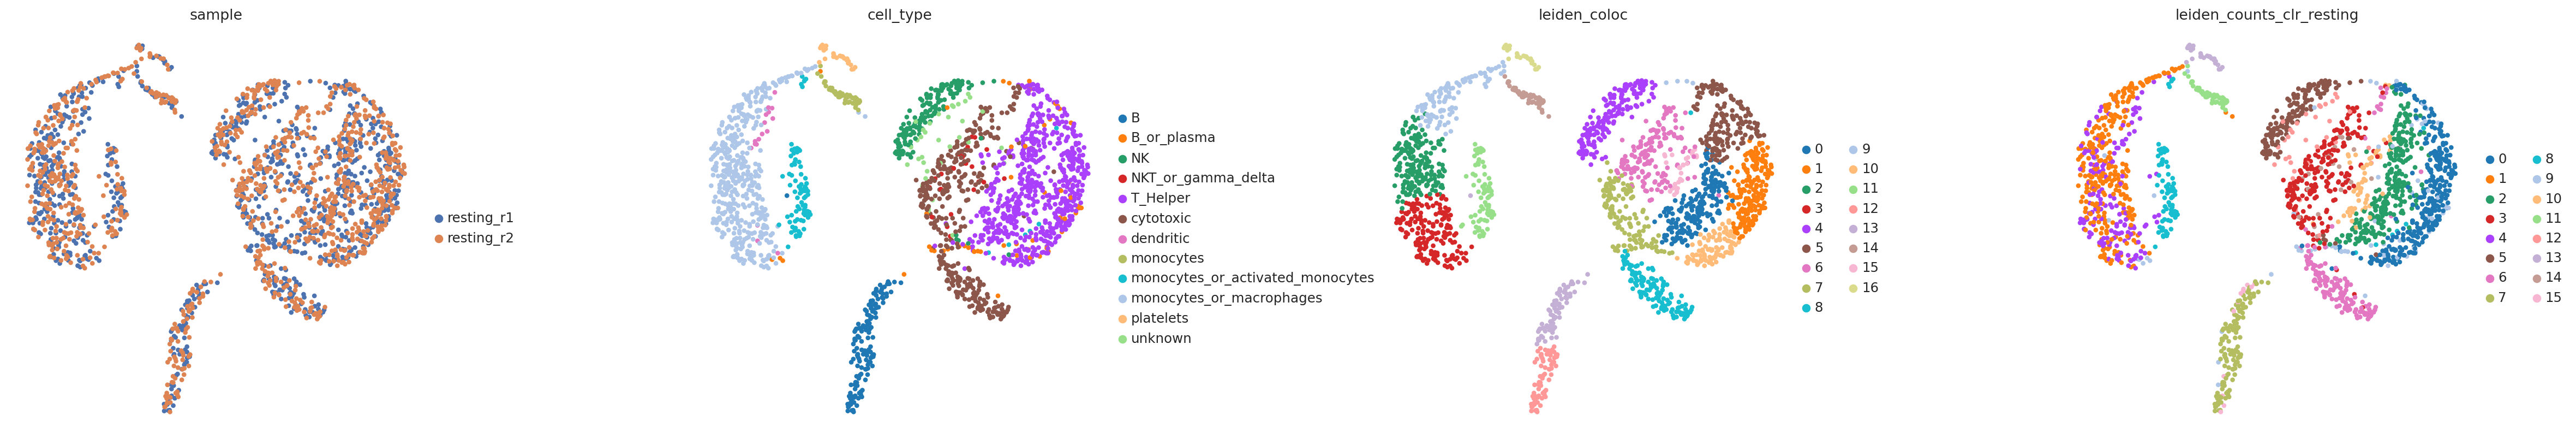

In [ ]:
sc.pp.neighbors(resting_coloc_adata, n_neighbors=15, random_state=0, key_added='neighbors_coloc')
sc.tl.leiden(resting_coloc_adata, resolution=1, random_state=0, key_added='leiden_coloc', flavor='leidenalg', neighbors_key='neighbors_coloc')
sc.tl.umap(resting_coloc_adata, neighbors_key='neighbors_coloc')
sc.pl.umap(resting_coloc_adata, color=['sample', 'cell_type', 'leiden_coloc', 'leiden_counts_clr_resting'], wspace=0.5)

In [ ]:
scvi.model.SCVI.setup_anndata(resting_coloc_adata, batch_key='sample',)
# search_space = {
#     "model_params": {"n_hidden": tune.choice([64, 128, 256]), "n_layers": tune.choice([1, 2, 3]), "dispersion": 'gene-cell', 'gene_likelihood': 'zinb', 'latent_distribution': 'normal'},
#     "train_params": {"max_epochs": 400, "plan_kwargs": {"lr": 1e-4}, "early_stopping": 50, 'train_size': 0.8},
# }
# results = autotune.run_autotune(scvi.model.SCVI, data=resting_adata, mode='min', metrics='validation_loss', search_space=search_space, num_samples=10, resources={'cpu': 10,})

resting_model = scvi.model.SCVI(resting_coloc_adata, n_hidden=128, n_layers=2, dispersion='gene-cell', gene_likelihood='zinb', latent_distribution='normal')
resting_model.train(train_size=0.8, check_val_every_n_epoch=1, early_stopping=50, plan_kwargs=dict(lr=3e-4, optimizer='Adam'))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 18979.963. Signaling Trainer to stop.


In [ ]:
# print(results.result_grid.get_dataframe()[['validation_loss', 'training_iteration', 'config/model_params/n_layers', 'config/model_params/n_hidden']].sort_values(by='validation_loss'))

<Axes: xlabel='epoch', ylabel='Loss'>

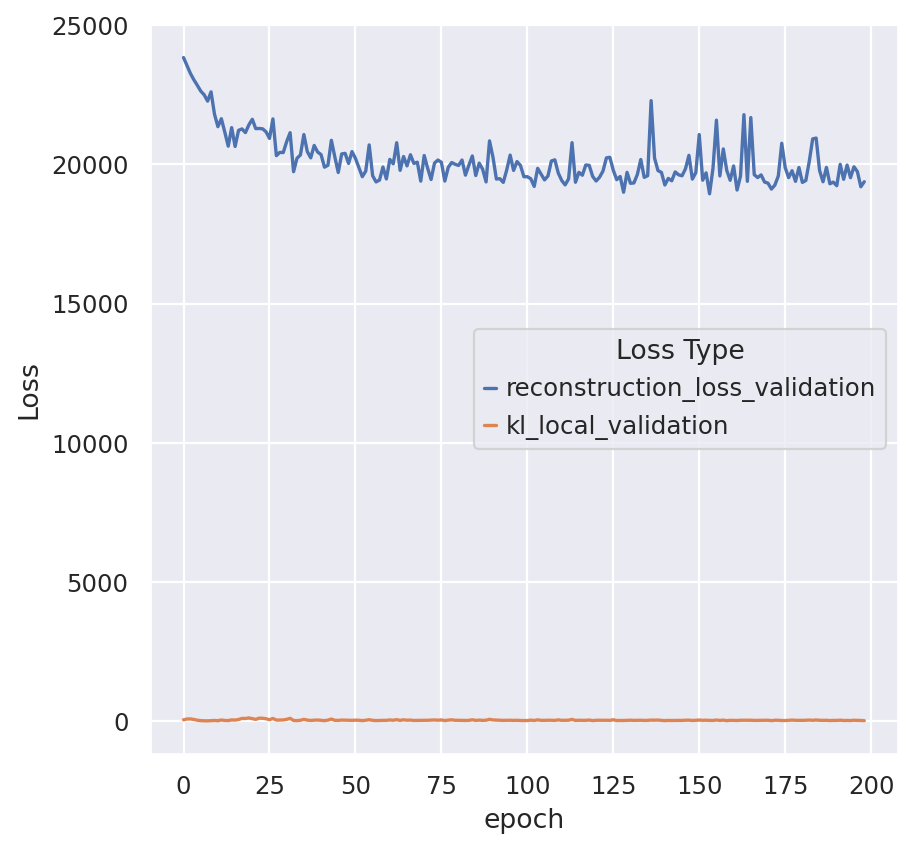

In [ ]:
n_epochs = len(resting_model.history['validation_loss'])
validation_losses = ['reconstruction_loss_validation', 'kl_local_validation']
# validation_losses = ['validation_loss', 'elbo_validation', 'reconstruction_loss_validation']
validation_df = pd.melt(pd.DataFrame({l: resting_model.history[l][l] for l in validation_losses}).reset_index(), id_vars=['epoch'], value_name='Loss', var_name='Loss Type')
sns.lineplot(validation_df, x='epoch', y='Loss', hue='Loss Type')

In [ ]:
resting_coloc_adata.obsm['scvi_coloc_latent'] = resting_model.get_latent_representation()
sc.pp.neighbors(resting_coloc_adata, n_neighbors=15, random_state=0, use_rep='scvi_coloc_latent', key_added='neighbors_scvi_coloc')
sc.tl.leiden(resting_coloc_adata, resolution=1, random_state=0, key_added='leiden_scvi_coloc', neighbors_key='neighbors_scvi_coloc', flavor='leidenalg')

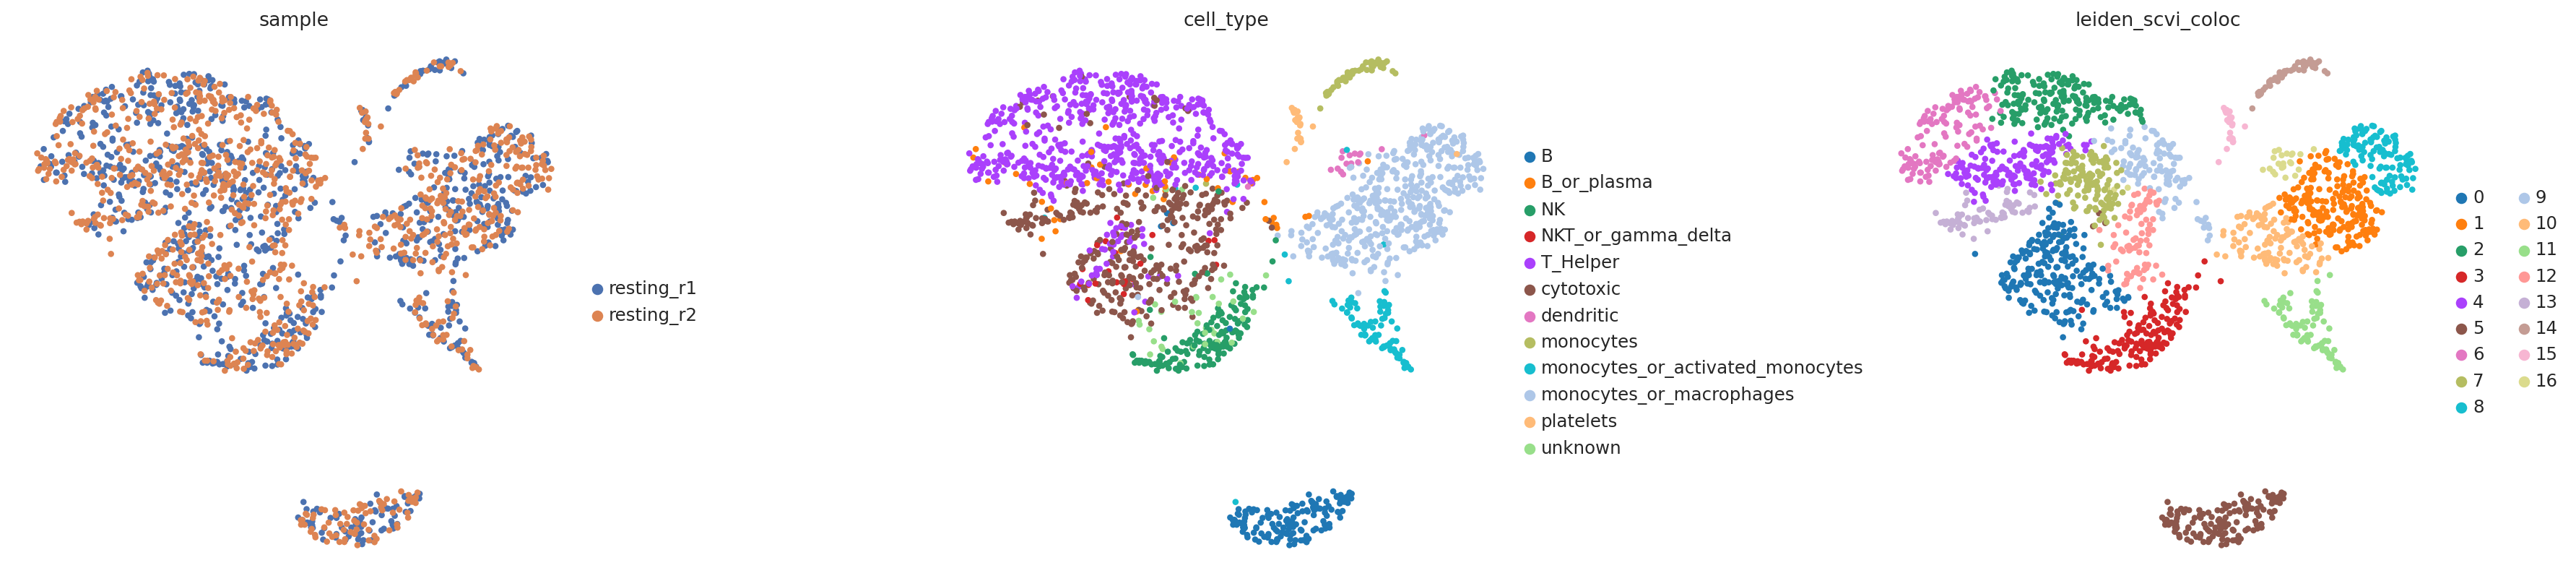

In [ ]:
sc.tl.umap(resting_coloc_adata, neighbors_key='neighbors_scvi_coloc')
sc.pl.umap(resting_coloc_adata, color=['sample', 'cell_type', 'leiden_scvi_coloc'], wspace=0.5)

In [ ]:
de_df = resting_model.differential_expression(
    groupby="cell_type",
)
de_df.columns

DE...:   0%|          | 0/12 [00:00<?, ?it/s]

Index(['proba_de', 'proba_not_de', 'bayes_factor', 'scale1', 'scale2',
       'pseudocounts', 'delta', 'lfc_mean', 'lfc_median', 'lfc_std', 'lfc_min',
       'lfc_max', 'raw_mean1', 'raw_mean2', 'non_zeros_proportion1',
       'non_zeros_proportion2', 'raw_normalized_mean1', 'raw_normalized_mean2',
       'is_de_fdr_0.05', 'comparison', 'group1', 'group2'],
      dtype='object')

In [ ]:
class PXLVI(BaseModuleClass):
    """Variational auto-encoder model for pixelgen data.

    Parameters
    ----------
    n_input
        Number of input genes.
    n_latent
        Dimensionality of the latent space.
    """

    def __init__(
        self,
        n_input: int,
        n_latent: int = 10,
    ):
        super().__init__()
        # in the init, we create the parameters of our elementary stochastic computation unit.

        # First, we setup the parameters of the generative model
        self.decoder = MyNeuralNet(n_latent, n_input, "softmax")
        self.log_theta = torch.nn.Parameter(torch.randn(n_input))

        # Second, we setup the parameters of the variational distribution
        self.mean_encoder = MyNeuralNet(n_input, n_latent, "none")
        self.var_encoder = MyNeuralNet(n_input, n_latent, "exp")

    def _get_inference_input(self, tensors: dict[str, torch.Tensor]) -> dict[str, torch.Tensor]:
        """Parse the dictionary to get appropriate args"""
        # let us fetch the raw counts, and add them to the dictionary
        return {"x": tensors[REGISTRY_KEYS.X_KEY]}

    @auto_move_data
    def inference(self, x: torch.Tensor) -> dict[str, torch.Tensor]:
        """
        High level inference method.

        Runs the inference (encoder) model.
        """
        # log the input to the variational distribution for numerical stability
        x_ = torch.log1p(x)
        # get variational parameters via the encoder networks
        qz_m = self.mean_encoder(x_)
        qz_v = self.var_encoder(x_)
        # get one sample to feed to the generative model
        # under the hood here is the Reparametrization trick (Rsample)
        z = Normal(qz_m, torch.sqrt(qz_v)).rsample()

        return {"qz_m": qz_m, "qz_v": qz_v, "z": z}

    def _get_generative_input(
        self, tensors: dict[str, torch.Tensor], inference_outputs: dict[str, torch.Tensor]
    ) -> dict[str, torch.Tensor]:
        return {
            "z": inference_outputs["z"],
            "library": torch.sum(tensors[REGISTRY_KEYS.X_KEY], dim=1, keepdim=True),
        }

    @auto_move_data
    def generative(self, z: torch.Tensor, library: torch.Tensor) -> dict[str, torch.Tensor]:
        """Runs the generative model."""
        # get the "normalized" mean of the negative binomial
        px_scale = self.decoder(z)
        # get the mean of the negative binomial
        px_rate = library * px_scale
        # get the dispersion parameter
        theta = torch.exp(self.log_theta)

        return {
            "px_scale": px_scale,
            "theta": theta,
            "px_rate": px_rate,
        }

    def loss(
        self,
        tensors: dict[str, torch.Tensor],
        inference_outputs: dict[str, torch.Tensor],
        generative_outputs: dict[str, torch.Tensor],
    ) -> LossOutput:
        # here, we would like to form the ELBO. There are two terms:
        #   1. one that pertains to the likelihood of the data
        #   2. one that pertains to the variational distribution
        # so we extract all the required information
        x = tensors[REGISTRY_KEYS.X_KEY]
        px_rate = generative_outputs["px_rate"]
        theta = generative_outputs["theta"]
        qz_m = inference_outputs["qz_m"]
        qz_v = inference_outputs["qz_v"]

        # term 1
        # the pytorch NB distribution uses a different parameterization
        # so we must apply a quick transformation (included in scvi-tools, but here we use the
        # pytorch code)
        nb_logits = (px_rate + 1e-4).log() - (theta + 1e-4).log()
        log_lik = NegativeBinomial(total_count=theta, logits=nb_logits).log_prob(x).sum(dim=-1)

        # term 2
        prior_dist = Normal(torch.zeros_like(qz_m), torch.ones_like(qz_v))
        var_post_dist = Normal(qz_m, torch.sqrt(qz_v))
        kl_divergence = kl(var_post_dist, prior_dist).sum(dim=1)

        elbo = log_lik - kl_divergence
        loss = torch.mean(-elbo)
        return LossOutput(
            loss=loss,
            reconstruction_loss=-log_lik,
            kl_local=kl_divergence,
            kl_global=0.0,
        )

In [ ]:
# search_space = {
#     "model_params": {"n_hidden": tune.choice([64, 128, 256]), "n_layers": tune.choice([1, 2, 3]), "dispersion": 'gene-cell', 'gene_likelihood': 'zinb', 'latent_distribution': 'normal'},
#     "train_params": {"max_epochs": 400, "plan_kwargs": {"lr": 1e-4}, "early_stopping": 50, 'train_size': 0.8},
# }
# results = autotune.run_autotune(scvi.model.SCVI, data=resting_adata, mode='min', metrics='validation_loss', search_space=search_space, num_samples=10, resources={'cpu': 10,})

In [ ]:
components = list(pg_data.adata.obs.index[0:300])
test_adata = pg_data.adata[pg_data.adata.obs.index.isin(components)]
results = convert_edgelist_to_protein_pair_colocalization(pg_data=pg_data, nbhd_radius=1, group_markers=True, detailed_info=True, components=components,)

# # marker_pair_coloc = pxl_utils.convert_edgelist_to_protein_pair_colocalization(pg_data=pg_data, nbhd_radius=1, group_markers=True, verbose=verbose, components=components, detailed_info=False)
# test_adata.obsm['marker_pair_coloc'] = results.layers['marker_pair_coloc']
# test_adata.obsm['marker_counts_and_pair_coloc'] = pd.concat((test_adata.to_df(layer='counts'), test_adata.obsm['marker_pair_coloc']), axis=1)
# test_adata.uns['coloc_info'] = results.info

# coloc_mean = test_adata.obsm['marker_pair_coloc'].mean(axis=0)
# coloc_var = test_adata.obsm['marker_pair_coloc'].var(axis=0)
# counts_mean = test_adata.to_df(layer='counts').mean(axis=0)
# counts_var = test_adata.to_df(layer='counts').var(axis=0)

# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# sns.scatterplot(x=coloc_mean, y=coloc_var, ax=ax[0], s=3)
# ax[0].loglog()
# sns.scatterplot(x=counts_mean, y=counts_var, ax=ax[1])
# ax[1].loglog()

# sns.histplot(test_adata.obsm['marker_counts_and_pair_coloc']['(CD20,CD69)'])

# nbhd_sizes = results.info['upi_connectivity'].groupby(['upia_int_0', 'component']).size()
# sns.histplot(nbhd_sizes, stat='density')
# print(nbhd_sizes.mean())
# print(nbhd_sizes.std())

/home/labs/nyosef/eitangr/miniconda3/envs/pixelgen-scvi-1/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_elem from `anndata.experimental` is deprecated. Import anndata.io.read_elem instead.
  warnings.warn(msg, FutureWarning)


[07/01/25 19:47:48]: Starting conversion...


  0%|          | 0/300 [00:55<?, ?it/s]


ComputeError: KeyboardInterrupt: 

In [ ]:
# coloc_adata = anndata.AnnData(
#     X=adata.obsm['marker_pair_intersection'], 
#     obs=adata.obs, 
#     obsm={'counts': adata.layers['counts'], 'counts_clr': adata.layers['clr'],},
#     layers={
#         'marker_pair_union': adata.obsm['marker_pair_union'],
#         'marker_pair_intersection': adata.obsm['marker_pair_intersection']
#     },
#     uns = {
#         'neighbors_counts_clr_both_samples': adata.uns['neighbors'],
#         'leiden_counts_clr_both_samples': adata.uns['leiden'],   
#     }
# )

# coloc_adata.layers['marker_pair_jaccard'] = coloc_adata.layers['marker_pair_intersection'] / coloc_adata.layers['marker_pair_union']
# print('Number of undefined jaccard indices over whole dataset:', np.isnan(coloc_adata.layers['marker_pair_jaccard']).sum())